# SC407 Project - Industrial Waste Classification

# Group 31

In [1]:
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import random

import tensorflow as tf
import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.regularizers import L1,L2
from keras.utils import plot_model
from keras import optimizers, losses, layers
from keras.applications import VGG16, ResNet50, DenseNet201, InceptionV3
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

2024-04-13 19:30:17.990554: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 19:30:17.990667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 19:30:18.122636: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1) Loding the dataset 

In [2]:
# Function To Load Dataset
def load_data(dir):
    images = []
    labels = []
    for label in os.listdir(dir):
        if label!='trash':
            for image in os.listdir(os.path.join(dir, label)):
                img = os.path.join(dir,label,image)
                img = cv2.imread(img)
                img = cv2.resize(img, (100,100))
                images.append(img)
                labels.append(label)
            print(label)
    
    images = np.array(images).reshape(-1,100,100,3)/255.0
    labels = np.array(labels).reshape(-1,1)
    return images, labels

In [3]:
print("Loading Dataset")
data, label = load_data('/kaggle/input/waste-management/dataset2')

print("\n")
print(data.shape)
print(label.shape)

Loading Dataset
metal
glass
paper
cardboard
plastic


(2390, 100, 100, 3)
(2390, 1)


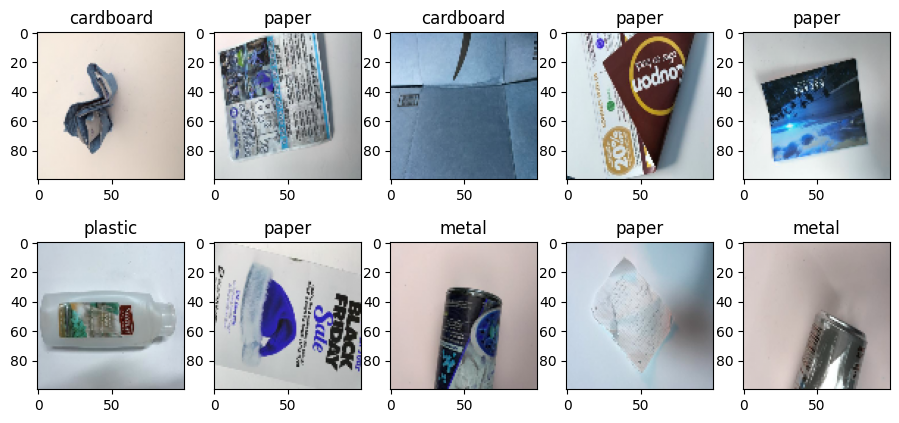

In [4]:
n = data.shape[0]
plt.figure(figsize=(11,5))
for i in range(10):
    idx = random.randint(0,n)
    plt.subplot(2,5,i+1)
    image = data[idx]
    plt.imshow(image)
    plt.title(label[idx][0])

## 2) Data Pre-Processing

In [5]:
le = LabelEncoder()
label = le.fit_transform(label)

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(data, label, test_size=.15, random_state=42)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.175, random_state=42)
print(xtrain.shape)
print(ytrain.shape)
print(xval.shape)
print(yval.shape)
print(xtest.shape)
print(ytest.shape)

(1675, 100, 100, 3)
(1675,)
(356, 100, 100, 3)
(356,)
(359, 100, 100, 3)
(359,)


## 3) A Simple Model

In [30]:
def block(input, filters):
  x = layers.Conv2D(filters, (3,3), padding='same', activation="relu")(input)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.2)(x)

  return x

def simple_model(input_shape,output_shape):
    inputs = keras.Input(shape=input_shape)
    x = block(inputs, 64)
    x = block(x, 128)
    x = block(x, 256)
    x = block(x, 512)
    
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation="relu")(x)

    outputs = layers.Dense(output_shape, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="simple_model")
    
    return model

In [31]:
model1=simple_model((100,100,3),5)
model1.summary()

Model: "simple_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 21,126,021 (80.59 MB)

 Trainable params: 21,121,029 (80.57 MB)

 Non-trainable params: 4,992 (19.50 KB)

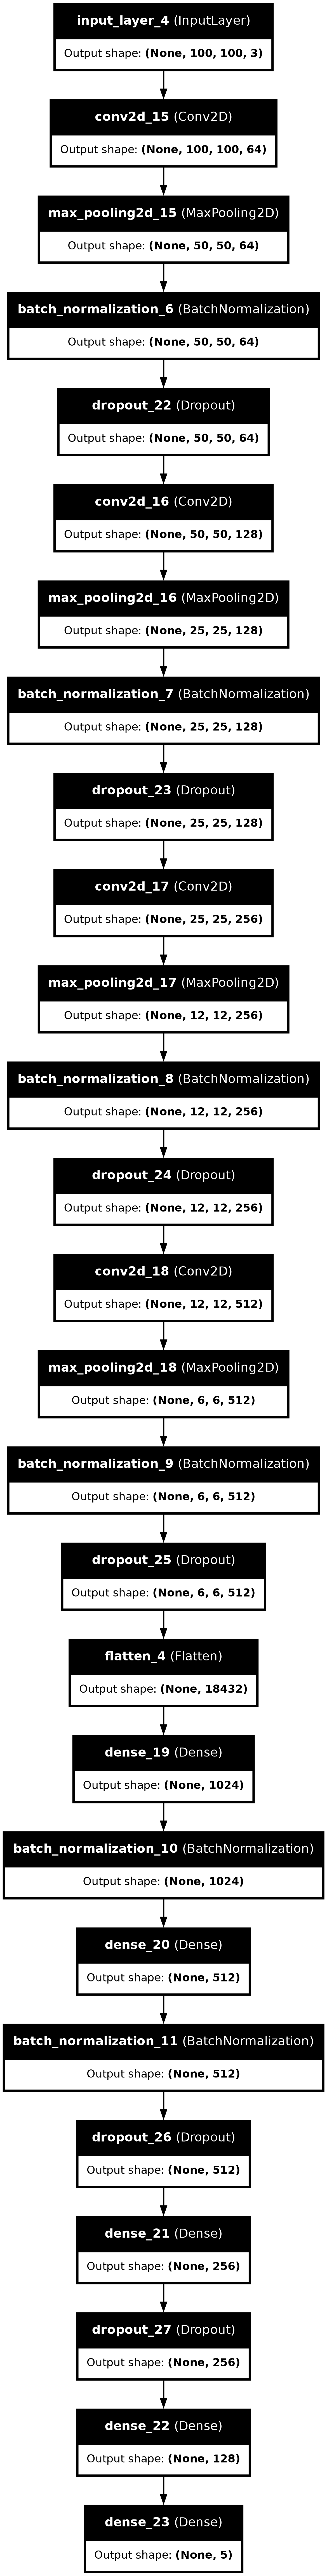

In [32]:
plot_model(model1, to_file='simple_model.png', show_shapes=True,show_layer_names=True)

In [33]:
model1.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(),
    metrics=["accuracy"],
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001)

chk_pt = ModelCheckpoint(filepath='checkpoint_simple.keras' ,monitor='val_loss', verbose=1, mode="min", save_best_only=True)

history = model1.fit(xtrain, ytrain, batch_size=64, epochs=100, validation_data=(xval, yval), callbacks=(reduce_lr,chk_pt))

Epoch 1/100
 5/27 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3088 - loss: 1.8523

W0000 00:00:1713037681.451475      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.4328 - loss: 1.5165

W0000 00:00:1713037694.394528      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 2.31318, saving model to checkpoint_simple.keras


W0000 00:00:1713037694.843134      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 555ms/step - accuracy: 0.4353 - loss: 1.5099 - val_accuracy: 0.2163 - val_loss: 2.3132 - learning_rate: 0.0010
Epoch 2/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6473 - loss: 0.9876
Epoch 2: val_loss did not improve from 2.31318
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6456 - loss: 0.9866 - val_accuracy: 0.2219 - val_loss: 2.5960 - learning_rate: 0.0010
Epoch 3/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6933 - loss: 0.8079
Epoch 3: val_loss did not improve from 2.31318
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6928 - loss: 0.8115 - val_accuracy: 0.2303 - val_loss: 2.8087 - learning_rate: 0.0010
Epoch 4/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7509 - loss: 0.6585
Epoch 4: val_loss improved from 2.31318 to 1.99180, saving model to checkpoint_simple.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7492 - loss: 0.6622 - val_accuracy: 0.2303 - val_loss: 1.9918 - learning_rate: 0

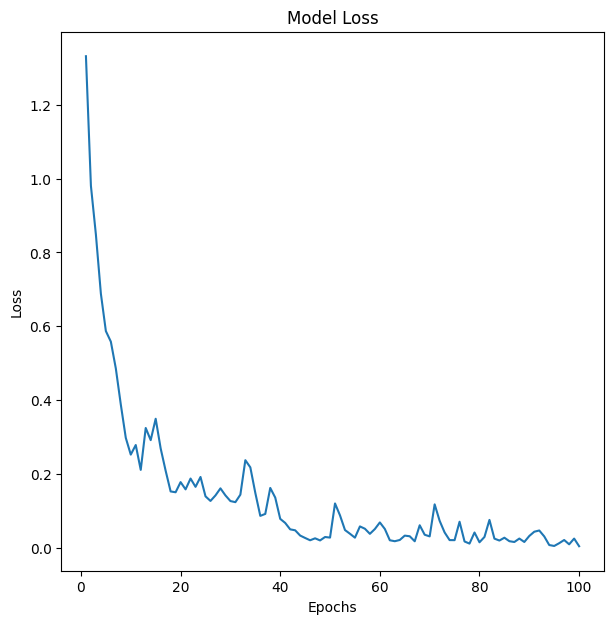

<Figure size 640x480 with 0 Axes>

In [34]:
plt.figure(figsize=(7,7))
model_loss = history.history['loss']
plt.plot(range(1,len(model_loss)+1), model_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.show()
plt.savefig('simple_model_loss.png')

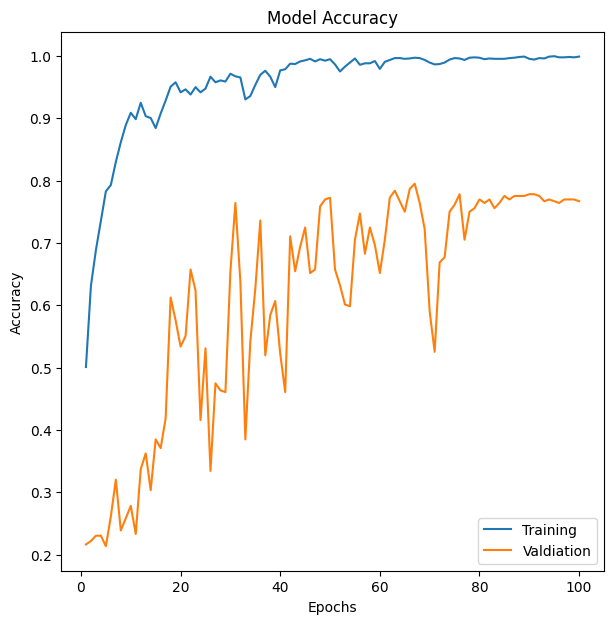

<Figure size 640x480 with 0 Axes>

In [35]:
plt.figure(figsize=(7,7))
model_acc = history.history['accuracy']
model_val_acc = history.history['val_accuracy']
plt.plot(range(1,len(model_loss)+1), model_acc)
plt.plot(range(1,len(model_loss)+1), model_val_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend(['Training', 'Valdiation'])
plt.show()
plt.savefig('simple_model_acc.png')

In [36]:
test_scores = model1.evaluate(xtest, ytest, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

12/12 - 3s - 235ms/step - accuracy: 0.7883 - loss: 1.1526


W0000 00:00:1713037858.413869      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test loss: 1.1525650024414062
Test accuracy: 0.7883008122444153


## 4) Multi-Headed Model

In [76]:
def multi_head_model(input_shape, output_shape, num_heads=3):
    inputs = layers.Input(shape=input_shape)
    
    # Shared convolutional base
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    
    # Create multiple heads
    outputs = []
    for _ in range(num_heads):
        # Each head has its own set of dense layers
        h = layers.Dense(64, activation='relu')(x)
        h = layers.BatchNormalization()(h)
        h = layers.Dropout(0.5)(h)
        h = layers.Dense(output_shape, activation='softmax')(h)
        outputs.append(h)
    
    # Combine outputs from all heads
    combined_output = layers.concatenate(outputs, axis=-1)
    
    # Create the model
    model = keras.Model(inputs=inputs, outputs=combined_output,name="multiheaded_model")
    return model

In [86]:
model2=multi_head_model((100,100,3),5,10)
model2.summary()

Model: "multiheaded_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 100, 100,  │      1,792 │ input_layer_13[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_44    │ (None, 50, 50,    │          0 │ conv2d_44[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        256 │ max_pooling2d_44… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_88          │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 50, 50,    │     73,856 │ dropout_88[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_45    │ (None, 25, 25,    │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        512 │ max_pooling2d_45… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_89          │ (None, 25, 25,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 25, 25,    │    295,168 │ dropout_89[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_46    │ (None, 12, 12,    │          0 │ conv2d_46[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │      1,024 │ max_pooling2d_46… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 36864)     │          0 │ batch_normalizat… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_118 (Dense)   │ (None, 64)        │  2,359,360 │ flatten_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_120 (Dense)   │ (None, 64)        │  2,359,360 │ flatten_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_122 (Dense)   │ (None, 64)        │  2,359,360 │ flatten_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_124 (Dense)   │ (None, 64)        │  2,359,360 │ flatten_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_126 (Dense)   │ (None, 64)        │  2,359,360 │ flatten_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,972,018 (91.45 MB)

 Trainable params: 23,969,842 (91.44 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [87]:
plot_model(model2, to_file='multi_headed_model.png', show_shapes=True,show_layer_names=True)

In [88]:
model2.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(),
    metrics=["accuracy"],
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001)

chk_pt = ModelCheckpoint(filepath='checkpoint_multiheaded.keras' ,monitor='val_loss', verbose=1, mode="min", save_best_only=True)

history = model2.fit(xtrain, ytrain, batch_size=64, epochs=100, validation_data=(xval, yval), callbacks=(reduce_lr,chk_pt))

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 975ms/step - accuracy: 0.1864 - loss: 3.7722
Epoch 1: val_loss improved from inf to 3.87944, saving model to checkpoint_multiheaded.keras


W0000 00:00:1713040164.866327      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.1898 - loss: 3.7698 - val_accuracy: 0.1854 - val_loss: 3.8794 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4336 - loss: 3.6178
Epoch 2: val_loss improved from 3.87944 to 3.86510, saving model to checkpoint_multiheaded.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.4343 - loss: 3.6169 - val_accuracy: 0.2079 - val_loss: 3.8651 - learning_rate: 0.0010
Epoch 3/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4979 - loss: 3.5642
Epoch 3: val_loss improved from 3.86510 to 3.86396, saving model to checkpoint_multiheaded.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.5008 - loss: 3.5630 - val_accuracy: 0.2528 - val_loss: 3.8640 - learning_rate: 0.0010
Epoch 4/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5709 - loss: 3.5130
Epoch 4: val_loss did not improve from 3.86396
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5720 - loss: 3.5135 - val_a

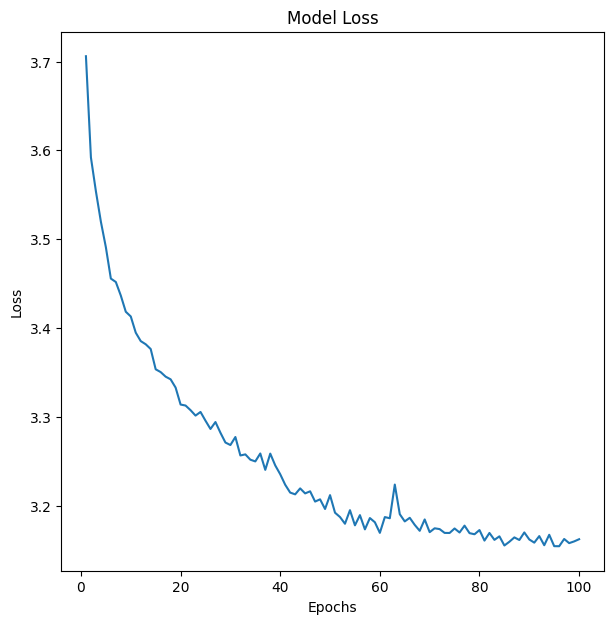

<Figure size 640x480 with 0 Axes>

In [89]:
plt.figure(figsize=(7,7))
model_loss = history.history['loss']
plt.plot(range(1,len(model_loss)+1), model_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.show()
plt.savefig('multi_headed_model_loss.png')

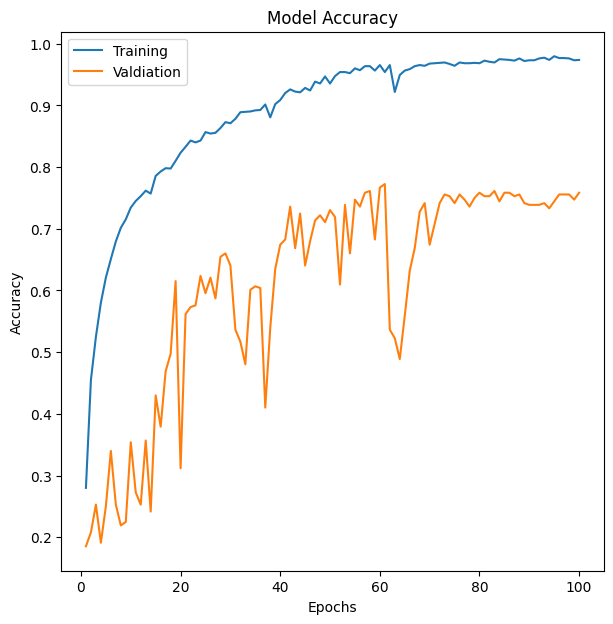

<Figure size 640x480 with 0 Axes>

In [90]:
plt.figure(figsize=(7,7))
model_acc = history.history['accuracy']
model_val_acc = history.history['val_accuracy']
plt.plot(range(1,len(model_loss)+1), model_acc)
plt.plot(range(1,len(model_loss)+1), model_val_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend(['Training', 'Valdiation'])
plt.show()
plt.savefig('multi_headed_model_acc.png')

In [91]:
test_scores = model2.evaluate(xtest, ytest, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

12/12 - 2s - 150ms/step - accuracy: 0.7437 - loss: 3.3875
Test loss: 3.387547492980957
Test accuracy: 0.7437325716018677


## 5) VGG16 Transfer Learning

In [98]:
def get_vgg(input_shape,output_shape):
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=(100,100,3))
    # Freeze layers in the base VGG16 model
    for layer in vgg.layers[:-3]:
        layer.trainable = False

    inputs = keras.Input(shape=(100,100,3))

    x = vgg(inputs)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Dense(5, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name='vgg')
    
    return model

In [99]:
model3=get_vgg((100,100,3),5)
model3.summary()

Model: "vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_95          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,313,989 (58.42 MB)

 Trainable params: 5,318,533 (20.29 MB)

 Non-trainable params: 9,995,456 (38.13 MB)

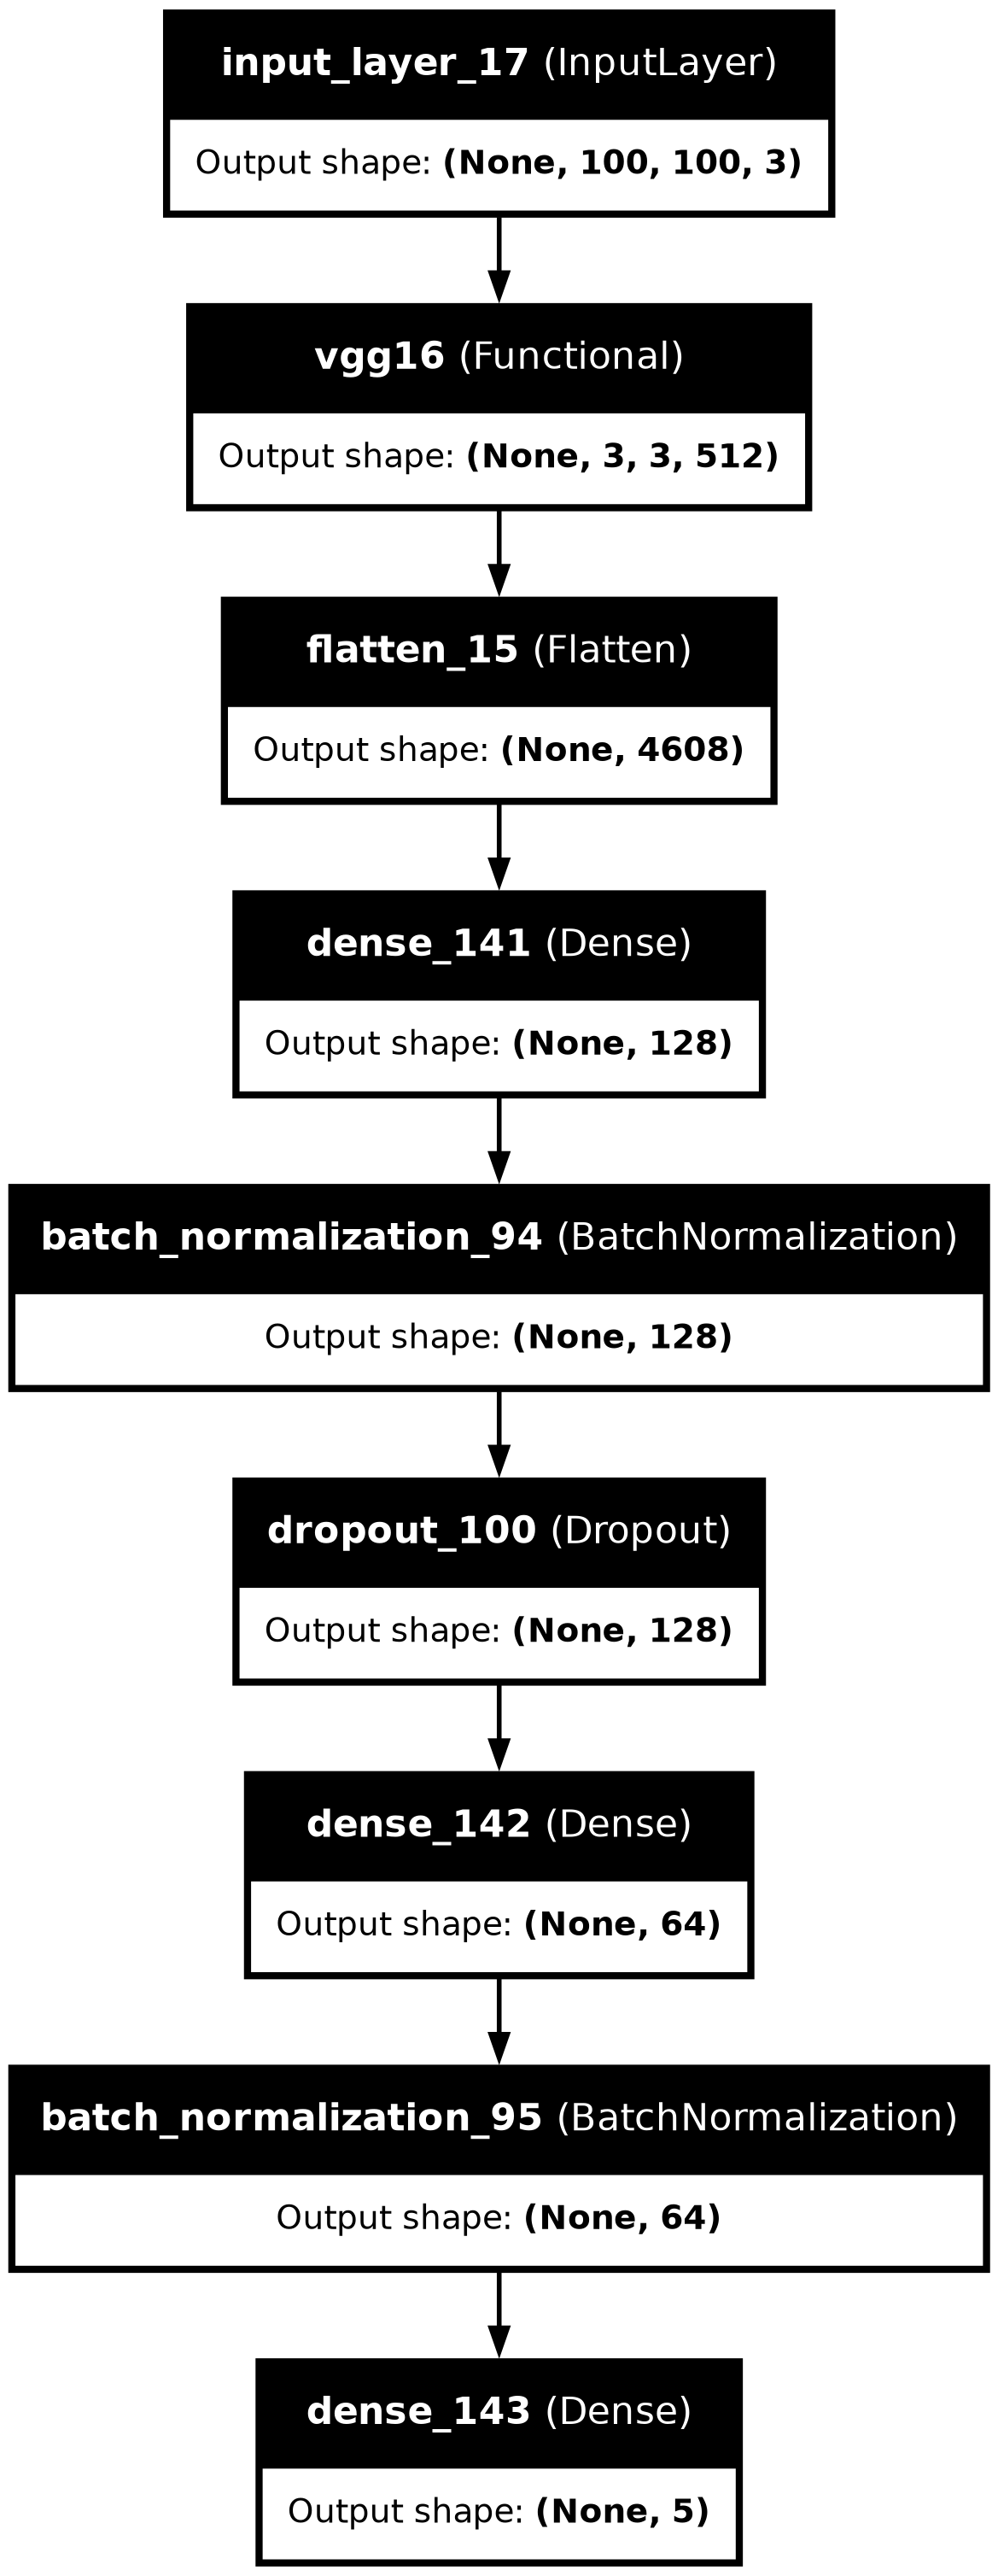

In [100]:
plot_model(model3, to_file='vgg_model.png', show_shapes=True,show_layer_names=True)

In [101]:
model3.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(),
    metrics=["accuracy"],
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001)

history = model3.fit(xtrain, ytrain, batch_size=64, epochs=100, validation_split=0.2, callbacks=(reduce_lr))

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 263ms/step - accuracy: 0.3755 - loss: 1.6032 - val_accuracy: 0.4149 - val_loss: 5.5822 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6300 - loss: 0.8900 - val_accuracy: 0.4776 - val_loss: 5.3363 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7583 - loss: 0.6619 - val_accuracy: 0.3791 - val_loss: 3.2090 - learning_rate: 0.0010
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8309 - loss: 0.4756 - val_accuracy: 0.7522 - val_loss: 0.6663 - learning_rate: 0.0010
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8959 - loss: 0.3229 - val_accuracy: 0.7821 - val_loss: 0.6308 - learning_rate: 0.0010
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9059 - loss: 0.3177 - val_accuracy: 0.7672 - val_loss: 0.7417 - learning_rate: 0.0010
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9336 - loss: 0.2172 

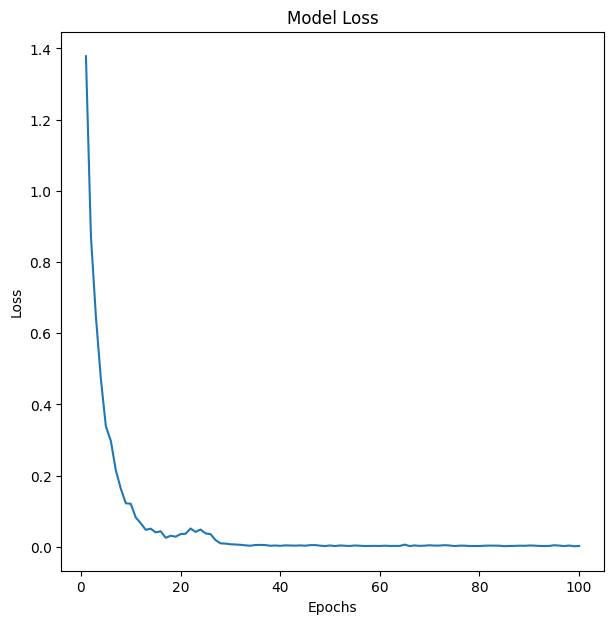

<Figure size 640x480 with 0 Axes>

In [102]:
plt.figure(figsize=(7,7))
model_loss = history.history['loss']
plt.plot(range(1,len(model_loss)+1), model_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.show()
plt.savefig('vgg_loss.png')

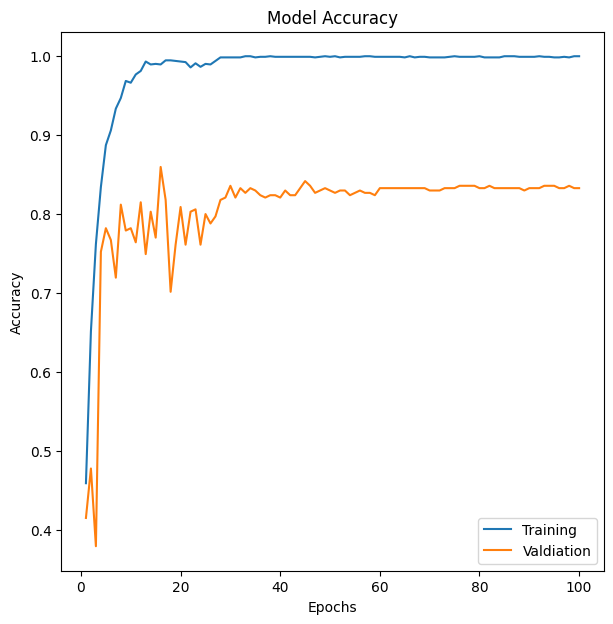

<Figure size 640x480 with 0 Axes>

In [103]:
plt.figure(figsize=(7,7))
model_acc = history.history['accuracy']
model_val_acc = history.history['val_accuracy']
plt.plot(range(1,len(model_loss)+1), model_acc)
plt.plot(range(1,len(model_loss)+1), model_val_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend(['Training', 'Valdiation'])
plt.show()
plt.savefig('vgg_acc.png')

In [104]:
test_scores = model3.evaluate(xtest, ytest, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

12/12 - 5s - 409ms/step - accuracy: 0.8273 - loss: 32519.2207
Test loss: 32519.220703125
Test accuracy: 0.8272980451583862
